In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

In [8]:
BASE = Path().resolve().parent.parent
RAW = BASE / 'thesis' / 'data' / 'original_data'
BLD = BASE/ 'thesis'/ 'data' / 'processed'
OUTPUT = BASE / 'thesis' / 'data' / 'outputs'

In [20]:

# 读取原始基本信息表
df_base = pd.read_csv(RAW/'csmar/基本信息/上市公司基本信息年度表215937759/STK_LISTEDCOINFOANL.csv', encoding='utf-8')

# 修正 Symbol 为6位股票代码
df_base['stock_id'] = df_base['Symbol'].apply(lambda x: str(x).zfill(6))
df_base['year'] = pd.to_datetime(df_base['EndDate']).dt.year

# 精简字段
df_master = df_base[['stock_id', 'year', 'IndustryCode']].drop_duplicates()

filtered_df = df_master[
    df_master['IndustryCode'].str.startswith('C') &
    df_master['year'].between(2014, 2019) &
    (df_master['stock_id'].astype(int).between(1, 609999))
]

# 结果
filtered_df.reset_index(drop=True, inplace=True)
filtered_df


,stock_id,year,IndustryCode
0,000004,2014,C27
1,000004,2015,C27
2,000004,2016,C27
3,000004,2017,C27
4,000004,2018,C27
...,...,...,...
12322,603998,2015,C27
12323,603998,2016,C27
12324,603998,2017,C27
12325,603998,2018,C27


In [129]:
# 1. executive_in_shareholder_firm 

def score_exec_in_shareholder():
    df = pd.read_csv(RAW / 'csmar/股东治理/高管兼任/CG_Rzgddw.csv')
    df['stock_id'] = df['Stkcd'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Reptdt']).dt.year

    df_leader = pd.read_csv(RAW / 'csmar/董事会治理/委员会数量:总经理董事长同一人/CG_Ybasic.csv')
    df_leader['stock_id'] = df_leader['Stkcd'].astype(str).str.zfill(6)
    df_leader['year'] = pd.to_datetime(df_leader['Reptdt']).dt.year
    df_leader = df_leader[['stock_id', 'year', 'Y0801b', 'Y0901b']].rename(columns={
        'Y0801b': 'ChairmanName',
        'Y0901b': 'ManagerName'
    })

    # 所有应评估的公司-年份组合（全集）
    all_firm_years = df_leader[['stock_id', 'year']].drop_duplicates()

    # 提取股东单位兼职记录
    df_shareholder = df[df['D0103b'] == 1].copy()
    df_shareholder['PersonName'] = df_shareholder['D0101b']

    # 合并董事长/总经理姓名
    df_merge = df_shareholder.merge(df_leader, on=['stock_id', 'year'], how='left')

    def classify_role(row):
        if row['PersonName'] == row['ChairmanName'] or row['PersonName'] == row['ManagerName']:
            return 'core'
        return 'normal'

    df_merge['part_time_role'] = df_merge.apply(classify_role, axis=1)

    # 聚合得分（只对存在兼职的公司-年）
    def assign_score_only(subdf):
        if (subdf['part_time_role'] == 'core').any():
            score = 1
        else:
            score = 5
        return pd.Series({'score_exec_in_shareholder': score})

    scored = (
        df_merge.groupby(['stock_id', 'year'], group_keys=False)
        .apply(assign_score_only, include_groups=False)
        .reset_index()
    )

    # 合并全集并补默认分
    result = all_firm_years.merge(scored, on=['stock_id', 'year'], how='left')
    result['score_exec_in_shareholder'] = result['score_exec_in_shareholder'].fillna(5)

    return result[['stock_id', 'year', 'score_exec_in_shareholder']]

df1 = score_exec_in_shareholder()
df1['score_exec_in_shareholder'].value_counts().sort_index()
df1

,stock_id,year,score_exec_in_shareholder
0,000002,2014,5.0
1,000002,2015,5.0
2,000002,2016,5.0
3,000002,2017,5.0
4,000002,2018,5.0
...,...,...,...
36167,873703,2023,5.0
36168,873706,2023,5.0
36169,873726,2023,5.0
36170,873806,2023,5.0


In [151]:
# 2. whether the controlling shareholder is a state-owned enterprise
def score_state_owned():
    df = pd.read_csv(RAW / 'csmar/董事会治理/董事会基本情况/BDT_ManaGovAbil.csv')
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Enddate']).dt.year

    def parse_nature(value):
        if pd.isna(value):
            return 3
        elif value == 1:
            return 1  # 国企
        elif value == 0:
            return 5  # 非国企
        else:
            return 3

    df['score_state_owned'] = df['ContrshrNature'].apply(parse_nature)

    return df[['stock_id', 'year', 'score_state_owned']]


df2 = score_state_owned()
df2['score_state_owned'].value_counts()


score_state_owned
5    24431
1    10740
3      955
Name: count, dtype: int64

In [54]:
# 3. separation of ownership and control ratio
def score_sep_own_ctrl():
    df = pd.read_csv(RAW/'csmar/董事会治理/董事会基本情况/BDT_ManaGovAbil.csv')
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Enddate']).dt.year
    df['score_sep_own_ctrl'] = df['ControllerSeperation'].apply(
        lambda x: 5 if x < 5 else 3 if x < 20 else 1
    )
    return df[['stock_id', 'year', 'score_sep_own_ctrl']]

df3 = score_sep_own_ctrl()
df3['score_sep_own_ctrl'].value_counts()

score_sep_own_ctrl
5    24520
3     8059
1     3547
Name: count, dtype: int64

In [24]:
# 4. 关联交易资产比例
def score_关联交易比例():
    df = pd.read_csv('original_data/csmar/股东治理/关联交易情况文件/RPT_Operation.csv')
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['EndDate']).dt.year
    df['score_关联交易比例'] = df['RelatedPartyRatio'].apply(lambda x: 5 if x == 0 else 3 if x <= 20 else 1)
    return df[['stock_id', 'year', 'score_关联交易比例']]

In [25]:
# 5. proportion of independent directors
def score_indep_dir_ratio():
    df = pd.read_csv(RAW/'csmar/董事会治理/董事会基本情况/BDT_ManaGovAbil.csv')
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Enddate']).dt.year
    df['score_indep_dir_ratio'] = df['IndDirectorRatio'].apply(
        lambda x: 5 if x >= 50 else 3 if x >= 30 else 1
    )
    return df[['stock_id', 'year', 'score_indep_dir_ratio']]

df5 = score_indep_dir_ratio()
df5['score_indep_dir_ratio'].value_counts()
df5


,stock_id,year,score_indep_dir_ratio
0,000002,2014,3
1,000002,2015,3
2,000002,2016,3
3,000002,2017,3
4,000002,2018,3
...,...,...,...
36121,873679,2023,3
36122,873693,2023,3
36123,873703,2023,3
36124,873726,2023,3


In [26]:
# 6. network centrality of independent directors
def score_indep_net_power():
    # 读取数据
    df = pd.read_csv(RAW/'csmar/董事会治理/董事会基本情况/BDT_ManaGovAbil.csv')
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Enddate']).dt.year

    # 填补缺失中心度为 0
    df['IndDirectorNetCentrality'] = df['IndDirectorNetCentrality'].fillna(0)

    # 按年份分组打分（中心度越高分越高）
    def assign_score(group):
        year = group.name
        q1 = group['IndDirectorNetCentrality'].quantile(1/3)
        q2 = group['IndDirectorNetCentrality'].quantile(2/3)
        def score(x):
            if x >= q2:
                return 5
            elif x >= q1:
                return 3
            else:
                return 1
        group['score_indep_net_power'] = group['IndDirectorNetCentrality'].apply(score)
        group['year'] = year
        return group

    df_scored = df.groupby('year', group_keys=False).apply(assign_score, include_groups=False)

    return df_scored[['stock_id', 'year', 'score_indep_net_power']]

df6 = score_indep_net_power()
df6['score_indep_net_power'].value_counts()


score_indep_net_power
3    13551
5    12390
1    10185
Name: count, dtype: int64

In [48]:
# 7. number of board meetings
def score_board_meetings():
    # 读取数据 #000511缺失2016的数据，不明原因
    df = pd.read_csv(RAW/'csmar/董事会治理/三会次数/CG_Agm.csv')
    df['stock_id'] = df['Stkcd'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Reptdt']).dt.year

    # 清洗非法值
    df['A0101b'] = df['A0101b'].replace(-9666, 0).fillna(0)
    


    # 打分规则
    def assign_score(val):
        if val >= 12:
            return 5
        elif val >= 8:
            return 3
        else:
            return 1


    df['score_board_meetings'] = df['A0101b'].apply(assign_score)

    return df[['stock_id', 'year', 'score_board_meetings']]


df7 = score_board_meetings()
df7['score_board_meetings'].value_counts()





score_board_meetings
3    15371
1    12027
5     8775
Name: count, dtype: int64

In [28]:
# 8. CEO与董事长是否为同一人
def score_concurrent():
    df = pd.read_csv(RAW/'csmar/董事会治理/董事会基本情况/BDT_ManaGovAbil.csv')
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Enddate']).dt.year
    df['score_concurrent'] = df['ConcurrentPosition'].apply(
        lambda x: 5 if x == 0 else 1
    )
    return df[['stock_id', 'year', 'score_concurrent']]

df8 = score_concurrent()
df8['score_concurrent'].value_counts()
df8

,stock_id,year,score_concurrent
0,000002,2014,5
1,000002,2015,5
2,000002,2016,5
3,000002,2017,1
4,000002,2018,5
...,...,...,...
36121,873679,2023,1
36122,873693,2023,1
36123,873703,2023,5
36124,873726,2023,1


In [29]:
# 9. number of established key committees
def score_committees():
    df = pd.read_csv(RAW/'csmar/董事会治理/委员会数量:总经理董事长同一人/CG_Ybasic.csv')
    df['stock_id'] = df['Stkcd'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Reptdt']).dt.year

    def assign_score(row):
        y1701b = row['Y1701b']
        y1701a = row['Y1701a']
        if pd.isna(y1701b):
            return 1
        if y1701b == 4:
            if not pd.isna(y1701a) and y1701a > 4:
                return 5
            else:
                return 3
        elif 2 <= y1701b <= 3:
            return 3
        else:
            return 1

    df['score_committees'] = df.apply(assign_score, axis=1)

    return df[['stock_id', 'year', 'score_committees']]

df9 = score_committees()
df9['score_committees'].value_counts()

score_committees
3    34305
5     1537
1      330
Name: count, dtype: int64

In [165]:
# 10. whether there are equity incentives 

def score_equity_incentive():
    df = pd.read_csv(RAW/'csmar/管理层治理/股权激励授予明细表/CG_EIAWARDLIST.csv')
    df['stock_id'] = df['Stkcd'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Gdate']).dt.year

    # 清洗：只保留 Progress 为“实施”或“完成”的记录
    df = df[df['Progress'].isin(['实施'])]

   

    # 授予数量大于0且日期合法才算有效激励记录
    df = df[(df['Grtstkta'] > 0) & (~df['year'].isna())]

    # 去重 + 打分（5表示存在股权激励）
    df_result = df[['stock_id', 'year']].drop_duplicates()
    df_result['score_equity_incentive'] = 5
    df_result['year'] = df['year'].astype(int)

    return df_result

df10 = score_equity_incentive()
df10

,stock_id,year,score_equity_incentive
0,000008,2016,5
4,000008,2017,5
12,000008,2019,5
14,000012,2017,5
16,000012,2018,5
...,...,...,...
7390,830879,2019,5
7393,833575,2019,5
7394,835368,2020,5
7396,873122,2019,5


In [31]:
# 11. managerial ownership ratio
def score_mgmt_ownership():
    df = pd.read_csv(RAW/'csmar/董事会治理/董事会基本情况/BDT_ManaGovAbil.csv')
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Enddate']).dt.year

    def assign_score(pct):
        if pd.isna(pct) or pct == 0:
            return 1
        elif 0 < pct < 0.05 or pct >= 0.15:
            return 3
        elif 0.05 <= pct < 0.15:
            return 5
        else:
            return 1

    df['score_mgmt_ownership'] = df['Mngmhldn'].apply(assign_score)
    return df[['stock_id', 'year', 'score_mgmt_ownership']]

df11 = score_mgmt_ownership()
df11['score_mgmt_ownership'].value_counts()

score_mgmt_ownership
3    27467
1     7296
5     1363
Name: count, dtype: int64

In [101]:
# 12. number of key committees meetings

def score_key_meet():
    # 读取数据
    df = pd.read_csv(RAW/'csmar/董事会治理/委员会召开情况表/CG_CommissionSta.csv')  # 请替换为实际路径
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['EndDate']).dt.year

    # 清洗提名委员会次数
    df['NominationCommitteeTimes'] = pd.to_numeric(df['NominationCommitteeTimes'], errors='coerce').fillna(0)
    df['RemAssComMemberTimes'] = pd.to_numeric(df['RemAssComMemberTimes'], errors='coerce').fillna(0)
    df['NominationCommitteeTimes'] = pd.to_numeric(df['NominationCommitteeTimes'], errors='coerce').fillna(0)

    # 打分规则
    def assign_score(audit, remass, nomination):
        present = sum([audit > 0, remass > 0, nomination > 0])
        if audit >= 6 and (remass >= 2 or nomination >= 2) and present >= 2:
            return 5
        elif audit >= 4 and (remass >= 1 or nomination >= 1):
            return 3
        else:
            return 1
        
    df['score_key_meet'] = df.apply(
    lambda row: assign_score(
        row['AuditCommitteeTimes'],
        row['RemAssComMemberTimes'],
        row['NominationCommitteeTimes']
    ),
    axis=1)

    #df['score_nom_meet'] = df['NominationCommitteeTimes'].apply(assign_score)

    return df[['stock_id', 'year', 'score_key_meet']]

df12 = score_key_meet()
df12['score_key_meet'].value_counts()


score_key_meet
3    5189
1    2917
5    1822
Name: count, dtype: int64

In [84]:
# 13. audit opinion
def score_audit_opinion():
    # 读取数据
    df = pd.read_csv(RAW/'csmar/信息披露/审计意见表文件/FIN_Audit.csv')  
    df['stock_id'] = df['Stkcd'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['Accper']).dt.year

    # 定义打分映射
    opinion_score_map = {
        '标准无保留意见': 5,
        '带有解释性说明的无保留意见': 3,
        '无保留意见加说明段': 3,
        '保留意见': 3,
        '保留意见加事项段': 3,
        '否定意见': 1,
        '否定意见加说明段': 1,
        '拒绝发表意见': 1,
        '无法表示意见': 1
    }

    # 映射打分
    df['score_audit_opinion'] = df['Audittyp'].map(opinion_score_map).fillna(0)

    return df[['stock_id', 'year', 'score_audit_opinion']]


df13 = score_audit_opinion()
df13['score_audit_opinion'].value_counts()

score_audit_opinion
5    21971
3     1001
1      170
Name: count, dtype: int64

In [34]:
# 14. whether there are financial misconduct disclosures

In [37]:
# 15.  information disclosure rating
def score_disclosure_rating():

    # 读取数据
    df = pd.read_csv(RAW /'csmar/信息披露/上市公司信息披露考评信息表/AIQ_LCInfoDisEvalY.csv')
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = df['EvaluationYear']

    # 定义打分规则
    def assign_score(val):
        if val == 1:  # 优秀
            return 5
        elif val == 2:  # 良好
            return 3
        elif val in [3, 4]:  # 合格 或 不合格
            return 1

    # 应用打分
    df['score_disclosure_rating'] = df['EvaluationResult'].apply(assign_score)

    return df[['stock_id', 'year', 'score_disclosure_rating']]



df15 = score_disclosure_rating()
df15['score_disclosure_rating'].value_counts()

score_disclosure_rating
3    19524
5     5589
1     4280
Name: count, dtype: int64

In [89]:
# 16. timeliness of annual report 

def score_timeliness():
    # 读取数据
    df = pd.read_csv(RAW/'csmar/信息披露/会计信息披露及时性指标表/AIQ_AccInfoDisTimeY.csv')  # 替换为实际路径
    df['stock_id'] = df['Symbol'].astype(str).str.zfill(6)
    df['year'] = pd.to_datetime(df['EndDate']).dt.year

    # 打分逻辑
    def assign_score(val):
        if pd.isna(val):
            return pd.NA
        elif val <= 90:
            return 5
        elif val <= 105:
            return 3
        else:
            return 1

    df['score_timeliness'] = df['TotalLagA'].apply(assign_score)

    return df[['stock_id', 'year', 'score_timeliness']]

df16 = score_timeliness()
df16['score_timeliness'].value_counts()

score_timeliness
1    12908
5     7651
3     3319
Name: count, dtype: int64

In [ ]:
# 17. accuracy of annual report performance forecasts 不要了

In [166]:
df_merged = filtered_df.copy()
for score_df in [df1, df2, df3, df5, df6, df7, df8, df9, df10, df11, df12, df13, df15, df16]:
    df_merged = df_merged.merge(score_df, on=['stock_id', 'year'], how='left')



df_merged_2 = df_merged.copy()
df_merged_2 = df_merged_2.sort_values(['stock_id', 'year'])  # 按公司和年份排序（必要）

# 用上一年的值补 score_disclosure_rating 的缺失
df_merged_2['score_disclosure_rating'] = (
    df_merged_2.sort_values(['stock_id', 'year'])  # 确保按时间顺序
    .groupby('stock_id')['score_disclosure_rating']
    .transform(lambda x: x.ffill().bfill())
)

df_merged_2





,stock_id,year,IndustryCode,score_exec_in_shareholder,score_state_owned,score_sep_own_ctrl,score_indep_dir_ratio,score_indep_net_power,score_board_meetings,score_concurrent,score_committees,score_equity_incentive,score_mgmt_ownership,score_key_meet,score_audit_opinion,score_disclosure_rating,score_timeliness
0,000004,2014,C27,5.0,5.0,3.0,3.0,3.0,1.0,5.0,3.0,NaN,3.0,1.0,5.0,3.0,1.0
1,000004,2015,C27,5.0,5.0,3.0,3.0,5.0,3.0,1.0,3.0,NaN,3.0,1.0,5.0,3.0,1.0
2,000004,2016,C27,5.0,5.0,3.0,3.0,3.0,3.0,1.0,3.0,NaN,3.0,1.0,5.0,3.0,3.0
3,000004,2017,C27,5.0,5.0,3.0,3.0,3.0,1.0,1.0,3.0,NaN,3.0,1.0,3.0,3.0,1.0
4,000004,2018,C27,5.0,5.0,3.0,3.0,3.0,3.0,1.0,3.0,NaN,3.0,1.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12322,603998,2015,C27,5.0,5.0,5.0,3.0,5.0,5.0,1.0,3.0,NaN,3.0,NaN,5.0,3.0,5.0
12323,603998,2016,C27,5.0,5.0,5.0,3.0,5.0,3.0,1.0,3.0,5.0,3.0,NaN,5.0,3.0,1.0
12324,603998,2017,C27,5.0,5.0,5.0,3.0,3.0,3.0,1.0,3.0,NaN,3.0,NaN,5.0,3.0,1.0
12325,603998,2018,C27,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,5.0,3.0,NaN,5.0,3.0,1.0


In [167]:
df_merged_2.isna().sum()


stock_id                         0
year                             0
IndustryCode                     0
score_exec_in_shareholder      680
score_state_owned              680
score_sep_own_ctrl             680
score_indep_dir_ratio          680
score_indep_net_power          680
score_board_meetings           681
score_concurrent               680
score_committees               680
score_equity_incentive       10962
score_mgmt_ownership           680
score_key_meet                7192
score_audit_opinion             96
score_disclosure_rating        814
score_timeliness                40
dtype: int64

In [168]:
rows_to_drop = df_merged_2[df_merged_2['score_exec_in_shareholder'].isna() & df_merged_2['score_state_owned'].isna()].index

# 删除这些行
df_cleaned = df_merged_2.drop(index=rows_to_drop)
df_cleaned['score_key_meet'] = df_cleaned['score_key_meet'].fillna(1)
df_cleaned['score_equity_incentive'] = df_cleaned['score_equity_incentive'].fillna(1)

df_cleaned.isna().sum()

stock_id                       0
year                           0
IndustryCode                   0
score_exec_in_shareholder      0
score_state_owned              0
score_sep_own_ctrl             0
score_indep_dir_ratio          0
score_indep_net_power          0
score_board_meetings           1
score_concurrent               0
score_committees               0
score_equity_incentive         0
score_mgmt_ownership           0
score_key_meet                 0
score_audit_opinion            0
score_disclosure_rating      134
score_timeliness               0
dtype: int64

In [115]:
df_cleaned.isna().sum()

stock_id                     0
year                         0
IndustryCode                 0
exec_in_shareholder          0
score_state_owned            0
score_sep_own_ctrl           0
score_indep_dir_ratio        0
score_indep_net_power        0
score_board_meetings         1
score_concurrent             0
score_committees             0
score_mgmt_ownership         0
score_key_meet               0
score_audit_opinion          0
score_disclosure_rating    134
score_timeliness             0
dtype: int64

In [198]:
df_years = df_cleaned[df_cleaned['year'].between(2014, 2019)]

# 统计每个公司有多少年数据
year_counts = df_years.groupby('stock_id')['year'].nunique()
valid_stocks = year_counts[year_counts == 6].index.tolist()
df_continuous = df_years[df_years['stock_id'].isin(valid_stocks)]
df_continuous

,stock_id,year,IndustryCode,score_exec_in_shareholder,score_state_owned,score_sep_own_ctrl,score_indep_dir_ratio,score_indep_net_power,score_board_meetings,score_concurrent,score_committees,score_equity_incentive,score_mgmt_ownership,score_key_meet,score_audit_opinion,score_disclosure_rating,score_timeliness
11,000012,2014,C30,5.0,3.0,5.0,3.0,5.0,3.0,5.0,3.0,1.0,3.0,1.0,5.0,5.0,5.0
12,000012,2015,C30,5.0,5.0,3.0,5.0,5.0,5.0,5.0,3.0,1.0,3.0,1.0,5.0,5.0,5.0
13,000012,2016,C30,1.0,5.0,3.0,3.0,3.0,5.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0
14,000012,2017,C30,1.0,5.0,3.0,3.0,5.0,5.0,5.0,3.0,5.0,3.0,1.0,5.0,1.0,1.0
15,000012,2018,C30,1.0,5.0,3.0,3.0,3.0,5.0,5.0,3.0,5.0,3.0,1.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12322,603998,2015,C27,5.0,5.0,5.0,3.0,5.0,5.0,1.0,3.0,1.0,3.0,1.0,5.0,3.0,5.0
12323,603998,2016,C27,5.0,5.0,5.0,3.0,5.0,3.0,1.0,3.0,5.0,3.0,1.0,5.0,3.0,1.0
12324,603998,2017,C27,5.0,5.0,5.0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,1.0,5.0,3.0,1.0
12325,603998,2018,C27,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,5.0,3.0,1.0,5.0,3.0,1.0


In [199]:
df_continuous.isna().sum()

stock_id                     0
year                         0
IndustryCode                 0
score_exec_in_shareholder    0
score_state_owned            0
score_sep_own_ctrl           0
score_indep_dir_ratio        0
score_indep_net_power        0
score_board_meetings         0
score_concurrent             0
score_committees             0
score_equity_incentive       0
score_mgmt_ownership         0
score_key_meet               0
score_audit_opinion          0
score_disclosure_rating      0
score_timeliness             0
dtype: int64

In [200]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


def normalize_governance_scores(df: pd.DataFrame) -> pd.DataFrame:
    # 找出所有以 score_ 开头的打分列
    score_cols = [col for col in df.columns if col.startswith("score_")]
    
    # 创建归一化器
    scaler = MinMaxScaler()
    
    # 归一化所有打分列
    df_norm = df.copy()
    df_norm[score_cols] = scaler.fit_transform(df[score_cols])
    
    # 计算总分（归一化后）
    df_norm["total_score_norm"] = df_norm[score_cols].sum(axis=1)/14 #按指标改
    
    return df_norm

score = normalize_governance_scores(df_continuous)
score

,stock_id,year,IndustryCode,score_exec_in_shareholder,score_state_owned,score_sep_own_ctrl,score_indep_dir_ratio,score_indep_net_power,score_board_meetings,score_concurrent,score_committees,score_equity_incentive,score_mgmt_ownership,score_key_meet,score_audit_opinion,score_disclosure_rating,score_timeliness,total_score_norm
11,000012,2014,C30,1.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,0.0,1.0,1.0,1.0,0.678571
12,000012,2015,C30,1.0,1.0,0.5,1.0,1.0,1.0,1.0,0.5,0.0,0.5,0.0,1.0,1.0,1.0,0.750000
13,000012,2016,C30,0.0,1.0,0.5,0.5,0.5,1.0,0.0,0.5,0.0,0.0,0.0,1.0,0.5,0.0,0.392857
14,000012,2017,C30,0.0,1.0,0.5,0.5,1.0,1.0,1.0,0.5,1.0,0.5,0.0,1.0,0.0,0.0,0.571429
15,000012,2018,C30,0.0,1.0,0.5,0.5,0.5,1.0,1.0,0.5,1.0,0.5,0.0,1.0,0.5,0.0,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12322,603998,2015,C27,1.0,1.0,1.0,0.5,1.0,1.0,0.0,0.5,0.0,0.5,0.0,1.0,0.5,1.0,0.642857
12323,603998,2016,C27,1.0,1.0,1.0,0.5,1.0,0.5,0.0,0.5,1.0,0.5,0.0,1.0,0.5,0.0,0.607143
12324,603998,2017,C27,1.0,1.0,1.0,0.5,0.5,0.5,0.0,0.5,0.0,0.5,0.0,1.0,0.5,0.0,0.500000
12325,603998,2018,C27,1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,0.5,0.0,1.0,0.5,0.0,0.714286


In [201]:
def summarize_total_scores(df: pd.DataFrame, total_score_col: str = "total_score_norm"):
    summary = df[total_score_col].describe()
    bins = pd.cut(df[total_score_col], bins=10)
    freq = bins.value_counts().sort_index()
    return summary, freq

def plot_score_distribution(df: pd.DataFrame):
    df['total_score_norm'].hist(bins=20)
    plt.xlabel('total_score_norm')
    plt.ylabel('Number of Companies')
    plt.title('Governance Score Distribution')
    plt.show()

summarize_total_scores(score)

(count    8616.000000
 mean        0.522185
 std         0.099070
 min         0.142857
 25%         0.464286
 50%         0.535714
 75%         0.571429
 max         0.857143
 Name: total_score_norm, dtype: float64,
 total_score_norm
 (0.142, 0.214]      11
 (0.214, 0.286]      60
 (0.286, 0.357]     159
 (0.357, 0.429]    1744
 (0.429, 0.5]      1053
 (0.5, 0.571]      3473
 (0.571, 0.643]     782
 (0.643, 0.714]     959
 (0.714, 0.786]     303
 (0.786, 0.857]      72
 Name: count, dtype: int64)

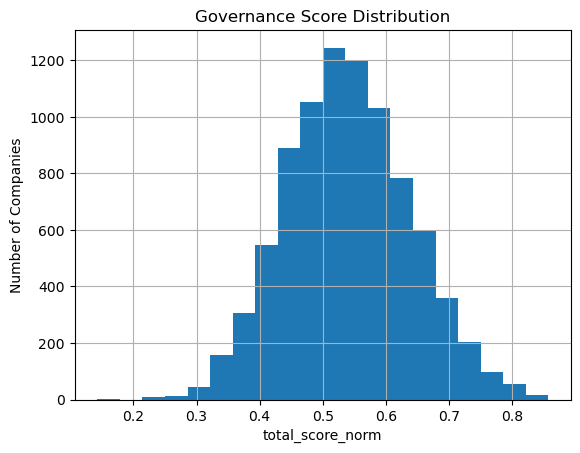

In [202]:
plot_score_distribution(score)

In [219]:
score.isna().sum()

stock_id                     0
year                         0
IndustryCode                 0
score_exec_in_shareholder    0
score_state_owned            0
score_sep_own_ctrl           0
score_indep_dir_ratio        0
score_indep_net_power        0
score_board_meetings         0
score_concurrent             0
score_committees             0
score_equity_incentive       0
score_mgmt_ownership         0
score_key_meet               0
score_audit_opinion          0
score_disclosure_rating      0
score_timeliness             0
total_score_norm             0
dtype: int64

In [221]:
output_path = BLD / 'score.parquet'
score.to_parquet(output_path, index=False)
score

,stock_id,year,IndustryCode,score_exec_in_shareholder,score_state_owned,score_sep_own_ctrl,score_indep_dir_ratio,score_indep_net_power,score_board_meetings,score_concurrent,score_committees,score_equity_incentive,score_mgmt_ownership,score_key_meet,score_audit_opinion,score_disclosure_rating,score_timeliness,total_score_norm
11,000012,2014,C30,1.0,0.5,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,0.0,1.0,1.0,1.0,0.678571
12,000012,2015,C30,1.0,1.0,0.5,1.0,1.0,1.0,1.0,0.5,0.0,0.5,0.0,1.0,1.0,1.0,0.750000
13,000012,2016,C30,0.0,1.0,0.5,0.5,0.5,1.0,0.0,0.5,0.0,0.0,0.0,1.0,0.5,0.0,0.392857
14,000012,2017,C30,0.0,1.0,0.5,0.5,1.0,1.0,1.0,0.5,1.0,0.5,0.0,1.0,0.0,0.0,0.571429
15,000012,2018,C30,0.0,1.0,0.5,0.5,0.5,1.0,1.0,0.5,1.0,0.5,0.0,1.0,0.5,0.0,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12322,603998,2015,C27,1.0,1.0,1.0,0.5,1.0,1.0,0.0,0.5,0.0,0.5,0.0,1.0,0.5,1.0,0.642857
12323,603998,2016,C27,1.0,1.0,1.0,0.5,1.0,0.5,0.0,0.5,1.0,0.5,0.0,1.0,0.5,0.0,0.607143
12324,603998,2017,C27,1.0,1.0,1.0,0.5,0.5,0.5,0.0,0.5,0.0,0.5,0.0,1.0,0.5,0.0,0.500000
12325,603998,2018,C27,1.0,1.0,1.0,0.5,1.0,1.0,1.0,0.5,1.0,0.5,0.0,1.0,0.5,0.0,0.714286


In [216]:
affected = pd.read_parquet(BLD/'affected_companies.parquet')

# 提取 impact_category == 1 的 treated 样本
treated_stocks = affected[affected['impact_category'] == 1]['Stkcd'].unique()

# 提取 impact_category != 1 的应被剔除的样本
excluded_stocks = affected[affected['impact_category'] != 1]['Stkcd'].unique()

# 先剔除应排除的样本
score_copy = score.copy()
score_copy = score_copy[~score_copy['stock_id'].isin(excluded_stocks)].copy()


# 添加 treated 和 post 列
score_copy['treated'] = score_copy['stock_id'].isin(treated_stocks).astype(int)
score_copy['post'] = (score_copy['year'] >= 2018).astype(int)

# 只保留指定列
df_did = score_copy[[
    'stock_id',
    'year',
    'IndustryCode',
    'treated',
    'post',
    'total_score_norm'
]]

df_did

,stock_id,year,IndustryCode,treated,post,total_score_norm
11,000012,2014,C30,0,0,0.678571
12,000012,2015,C30,0,0,0.750000
13,000012,2016,C30,0,0,0.392857
14,000012,2017,C30,0,0,0.571429
15,000012,2018,C30,0,1,0.571429
...,...,...,...,...,...,...
12322,603998,2015,C27,0,0,0.642857
12323,603998,2016,C27,0,0,0.607143
12324,603998,2017,C27,0,0,0.500000
12325,603998,2018,C27,0,1,0.714286


In [217]:
df_did[df_did['treated']==1]

,stock_id,year,IndustryCode,treated,post,total_score_norm
341,000541,2014,C38,1,0,0.535714
342,000541,2015,C38,1,0,0.500000
343,000541,2016,C38,1,0,0.464286
344,000541,2017,C38,1,0,0.500000
345,000541,2018,C38,1,1,0.464286
...,...,...,...,...,...,...
11747,603600,2015,C21,1,0,0.357143
11748,603600,2016,C21,1,0,0.464286
11749,603600,2017,C21,1,0,0.464286
11750,603600,2018,C21,1,1,0.357143


In [218]:
df_did.groupby('treated')['total_score_norm'].describe()


,count,mean,std,min,25%,50%,75%,max
treated,,,,,,,,
0,8184.0,0.521401,0.098731,0.142857,0.464286,0.535714,0.571429,0.857143
1,366.0,0.537861,0.104696,0.321429,0.464286,0.535714,0.607143,0.821429


In [209]:
affected

,Stkcd
0,000541
1,002004
2,002009
3,002084
4,002101
...,...
78,603355
79,603600
80,603703
81,603800


In [205]:
affected_ids = set(affected['Stkcd'])
governance_ids = set(score['stock_id'])

In [208]:
len(missing_ids)

22

In [206]:
all_present = affected_ids.issubset(governance_ids)
if not all_present:
    missing_ids = affected_ids - governance_ids
    print("缺失的公司代码有：", sorted(missing_ids))

缺失的公司代码有： ['002795', '300394', '300443', '300445', '300562', '300570', '300580', '300582', '300590', '430418', '603085', '603089', '603090', '603131', '603238', '603313', '603315', '603338', '603355', '603703', '603800', '603968']


In [189]:
filtered_df[filtered_df['stock_id'] == '300443']

,stock_id,year,IndustryCode
7222,300443,2015,C35
7223,300443,2016,C35
7224,300443,2017,C35
7225,300443,2018,C35
7226,300443,2019,C35


In [190]:
# 设定需要连续存在的年份集合
target_years = set(range(2015, 2020))

# 分组后取每个公司出现的年份集合
grouped_years = score.groupby('stock_id')['year'].apply(set)

# 保留年份集合中包含所有目标年份的公司
valid_ids = grouped_years[grouped_years.apply(lambda years: target_years.issubset(years))].index.tolist()

# 输出结果
df_valid = score[score['stock_id'].isin(valid_ids)]
governance_ids_2 = set(df_valid['stock_id'])
all_present = affected_ids.issubset(governance_ids)
if not all_present:
    missing_ids = affected_ids - governance_ids_2
    print("缺失的公司代码有：", sorted(missing_ids))

缺失的公司代码有： ['002795', '300562', '300570', '300580', '300582', '300590', '430418', '603089', '603090', '603131', '603238', '603313']


In [195]:
score[score['stock_id'] == '603313']


,stock_id,year,IndustryCode,score_exec_in_shareholder,score_state_owned,score_sep_own_ctrl,score_indep_dir_ratio,score_indep_net_power,score_board_meetings,score_concurrent,score_committees,score_equity_incentive,score_mgmt_ownership,score_key_meet,score_audit_opinion,score_disclosure_rating,score_timeliness,total_score_norm
11442,603313,2016,C21,1.0,1.0,1.0,0.5,0.5,1.0,0.0,0.5,0.0,0.5,0.0,1.0,0.5,0.0,0.535714
11443,603313,2017,C21,1.0,1.0,1.0,0.5,0.5,1.0,0.0,0.5,0.0,0.5,0.0,1.0,0.5,1.0,0.607143
11444,603313,2018,C21,1.0,1.0,1.0,1.0,0.5,1.0,0.0,0.5,0.0,0.5,0.0,1.0,0.5,1.0,0.642857
11445,603313,2019,C21,1.0,1.0,1.0,0.5,0.5,1.0,0.0,0.5,1.0,0.5,0.0,1.0,0.5,0.0,0.607143


In [197]:
len(governance_ids)

1436